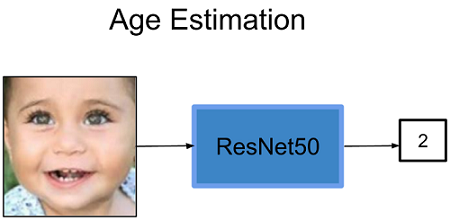

# **Import Libs**

In [ ]:
!rm -rf /content/sample_data

In [ ]:
pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 12.2 MB/s eta 0:00:00


In [ ]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2 as cv
import PIL
from PIL import Image

import sklearn
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch import optim
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import make_grid

import tqdm
import torchmetrics as tm

In [ ]:
!python --version

Python 3.10.12


In [ ]:
for lib in [np, pd, cv, PIL, sklearn, torch, torchvision, tqdm, tm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.23.5
pandas --> 1.5.3
cv2 --> 4.8.0
PIL --> 9.4.0
sklearn --> 1.2.2
torch --> 2.0.1+cu118
torchvision --> 0.15.2+cu118
tqdm --> 4.66.1
torchmetrics --> 1.2.0


# **Utils**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# **Dataset**

## **Load images from google drive**

In [ ]:
!mkdir dataset

In [ ]:
!tar -xzf /content/drive/MyDrive/Age_Estimation/UTKFace.tar.gz -C /content/dataset

## **EDA**

### **explore the images in the dataset!**

In [ ]:
images_folder = os.listdir('/content/dataset/UTKFace')
print("Len Of Images: ", len(images_folder))

Len Of Images:  23708


**Show some random images**

In [ ]:
def show_imgs(index):
  selected_files = random.sample(images_folder, index)
  plt.figure(figsize=(5, 5))
  for i, imgf in enumerate(selected_files):
    im = Image.open(os.path.join("/content/dataset/UTKFace", imgf))
    splits = imgf.split('_')
    age = splits[0]
    gender = splits[1]
    race = splits[2]
    racename = ['White', 'Black', 'Asian', 'Indian', 'Others']
    race = racename[int(race)]
    gender = 'male' if gender=='0' else 'female'
    plt.subplot(index//4+1,4,i+1)
    plt.imshow(im)
    plt.title(f"age: {age}\n gender: {gender}\n race: {race}", fontsize = 10)
    plt.axis('off')
  plt.tight_layout()
  plt.show()

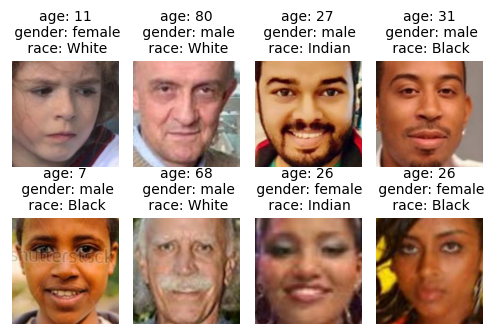

In [ ]:
show_imgs(8)

## **Create CSV file**

In [ ]:
image_names = []
ages = []
ethnicities = []
genders = []

for img in images_folder:
  splits = img.split('_')
  if len(splits) < 4:
    continue
  image_name = img
  age = int(splits[0])
  ethnicity = splits[2]
  ethnicity_dict = ['White', 'Black', 'Asian', 'Indian', 'Others']
  ethnicity = ethnicity_dict[int(ethnicity)]
  gender = splits[1]
  gender = 'Male' if gender == '0' else 'Female'
  if age > 80:
    continue
  image_names.append(image_name)
  ages.append(age)
  ethnicities.append(ethnicity)
  genders.append(gender)

all_data = {'image_name': image_names,
            'age': ages,
            'ethnicity': ethnicities,
            'gender': genders}
df = pd.DataFrame(all_data)
df.to_csv('/content/dataset/all_data.csv', index = False)

In [ ]:
df.head()

,image_name,age,ethnicity,gender
0,1_1_2_20161219202852780.jpg.chip.jpg,1,Asian,Female
1,4_0_0_20170110213547600.jpg.chip.jpg,4,White,Male
2,55_0_3_20170119205116040.jpg.chip.jpg,55,Indian,Male
3,14_1_0_20170103201911744.jpg.chip.jpg,14,White,Female
4,27_1_2_20161219192627707.jpg.chip.jpg,27,Asian,Female


## **EDA2**

### **Plot histogram for age**

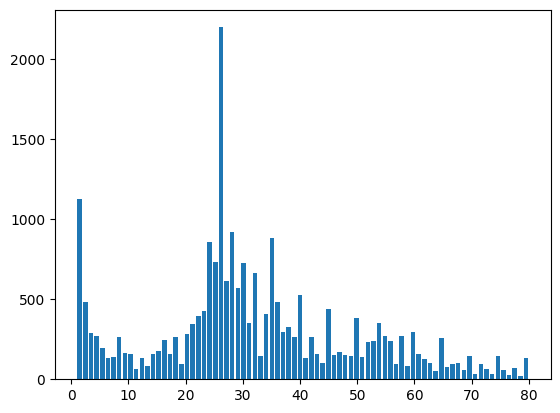

In [ ]:
plt.hist(df.age, bins = len(df.age.unique()), rwidth=0.8);

In [ ]:
df.age.describe()

count    23165.000000
mean        32.024218
std         18.227409
min          1.000000
25%         23.000000
50%         29.000000
75%         42.000000
max         80.000000
Name: age, dtype: float64

### **Plot histogram for gender**

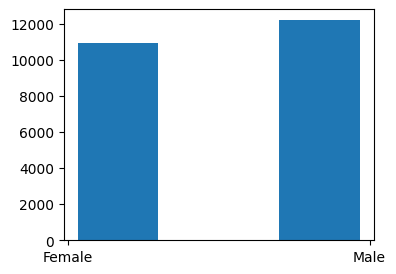

In [ ]:
plt.figure(figsize=(4,3))
plt.hist(df.gender, bins = len(df.gender.unique())+1, rwidth = 0.8);

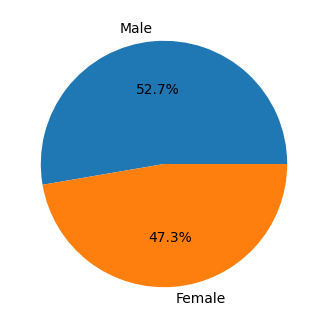

In [ ]:
plt.figure(figsize=(4,4))

y = [df.gender.value_counts()[0], df.gender.value_counts()[1]]
mylabels = ["Male", "Female"]

# fig, ax = plt.subplots()
plt.pie(y, labels=mylabels, autopct='%1.1f%%')
plt.show()

### **Plot histogram for ethnicity**

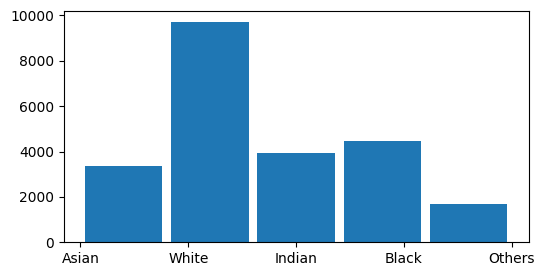

In [ ]:
plt.figure(figsize=(6,3))
plt.hist(df.ethnicity, bins = len(df.ethnicity.unique()), rwidth = 0.9);

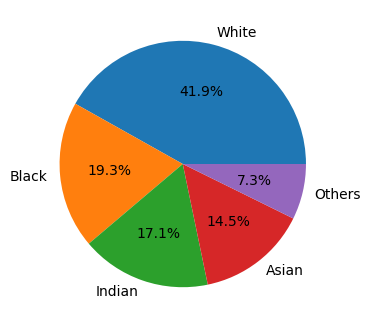

In [ ]:
plt.figure(figsize=(4,4))

y = [df.ethnicity.value_counts()[0], df.ethnicity.value_counts()[1], df.ethnicity.value_counts()[2], df.ethnicity.value_counts()[3], df.ethnicity.value_counts()[4]]
mylabels = ["White", "Black", "Indian", "Asian", "Others"]

# fig, ax = plt.subplots()
plt.pie(y, labels=mylabels, autopct='%1.1f%%')
plt.show()

In [ ]:
df.ethnicity.value_counts()

White     9698
Black     4478
Indian    3952
Asian     3348
Others    1689
Name: ethnicity, dtype: int64

### **Plot crosstab**

In [ ]:
pd.crosstab(index = df.gender, columns = df.ethnicity)

ethnicity,Asian,Black,Indian,Others,White
gender,,,,,
Female,1810,2182,1698,930,4337
Male,1538,2296,2254,759,5361


### **violin plots**

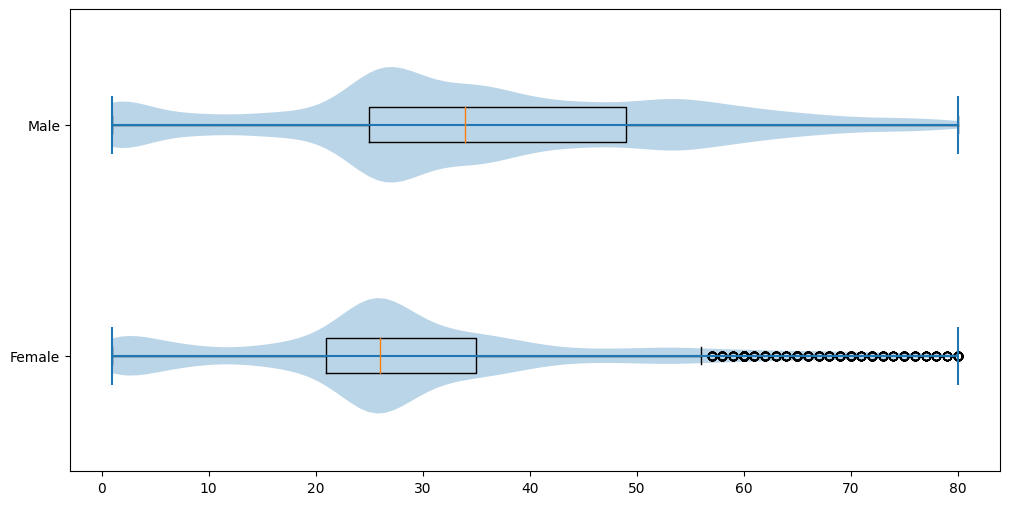

In [ ]:
plt.figure(figsize=(12, 6))
plt.boxplot([df.age[df.gender == cat] for cat in df.gender.unique()], vert=False, labels=df.gender.unique())
plt.violinplot([df.age[df.gender == cat] for cat in df.gender.unique()], vert=False);

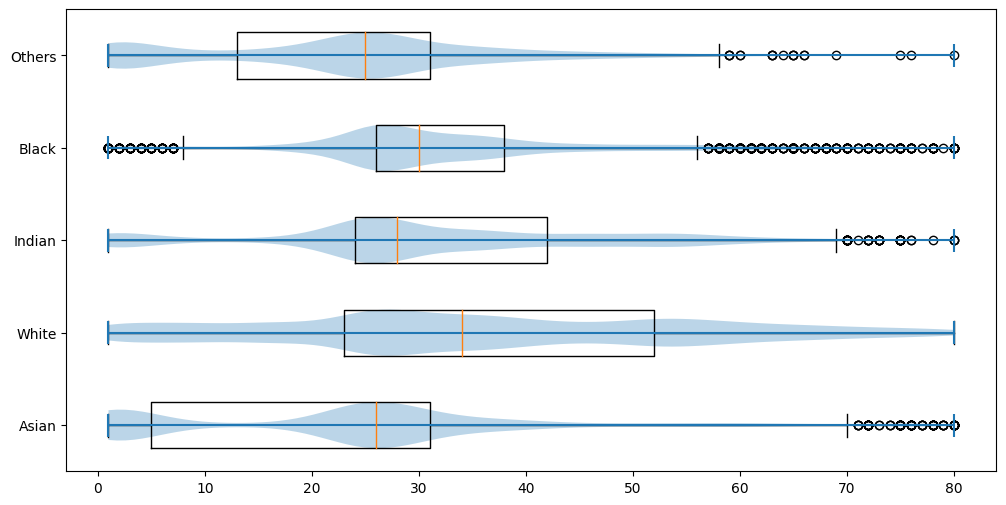

In [ ]:
plt.figure(figsize=(12,6))
plt.boxplot([df.age[df.ethnicity == temp] for temp in df.ethnicity.unique()], labels = df.ethnicity.unique(), vert = False);
plt.violinplot([df.age[df.ethnicity == temp] for temp in df.ethnicity.unique()],vert = False);

## **Split Dataset**

In [ ]:
df_train, temp = train_test_split(df, test_size=0.3, stratify=df.age, random_state=42)
df_test, df_valid = train_test_split(temp, test_size=0.5, stratify=temp.age, random_state=42)

df_train.shape, df_test.shape, df_valid.shape

((16215, 4), (3475, 4), (3475, 4))

**Splits distribution**

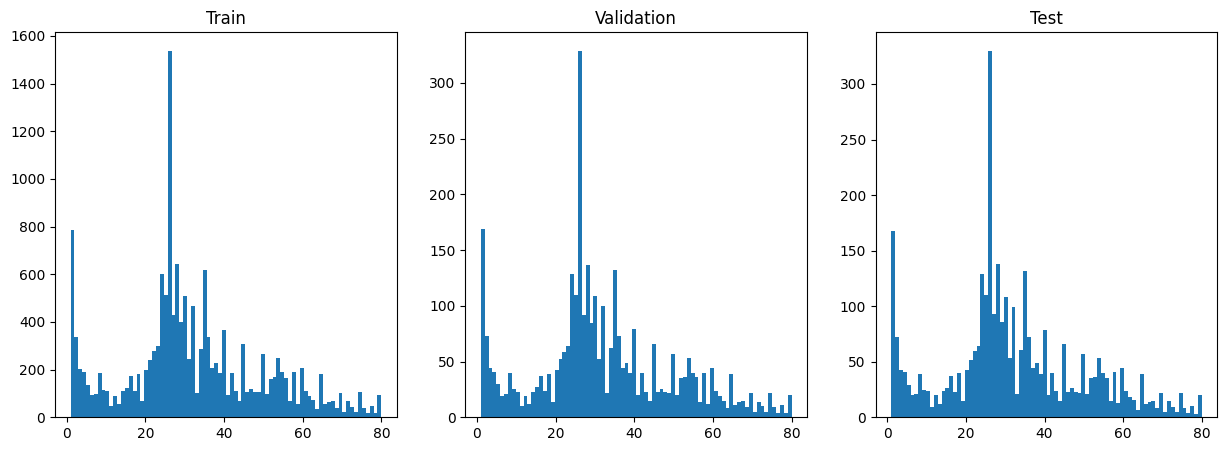

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(df_train.age, bins=len(df_train.age.unique())); axes[0].set_title('Train')
axes[1].hist(df_valid.age, bins=len(df_valid.age.unique())); axes[1].set_title('Validation')
axes[2].hist(df_test.age, bins=len(df_test.age.unique())); axes[2].set_title('Test');

**Save the training, validation, and test sets in separate CSV files.**

In [ ]:
df_train.to_csv('/content/train_set.csv', index=False)
df_valid.to_csv('/content/valid_set.csv', index=False)
df_test.to_csv('/content/test_set.csv', index=False)

print('All CSV files created successfully.')

All CSV files created successfully.


## **Transformation**

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## **Custom dataset**

In [ ]:
class UTKDataset(Dataset):

    def __init__(self, root_dir, csv_file, transform=None):
      self.root_dir = root_dir
      self.csv_file = csv_file
      self.transform = transform
      self.data = pd.read_csv(csv_file)
      # self.gender_dict = {'Male': 0, 'Female': 1}

    def __len__(self):
      return len(self.data)

    def __getitem__(self, idx):
      sample = self.data.iloc[idx, :]

      img_name = sample.image_name
      img = Image.open(os.path.join(self.root_dir, img_name))

      age = torch.tensor([sample.age], dtype=torch.float32)
      # gender = torch.tensor(self.gender_dict[sample.gender], dtype=torch.int32)
      # ethnicity = sample.ethnicity

      img = self.transform(img)

      return img, age

In [ ]:
dataset_dir = '/content/dataset/UTKFace'  # Dataset directory path

train_set = UTKDataset(root_dir=dataset_dir, csv_file='/content/train_set.csv', transform=train_transform)
valid_set = UTKDataset(root_dir=dataset_dir, csv_file='/content/valid_set.csv', transform=test_transform)
test_set = UTKDataset(root_dir=dataset_dir, csv_file='/content/test_set.csv', transform=test_transform)

In [ ]:
img, age = train_set[10]
img

tensor([[[-2.0323, -2.0323, -2.0323,  ..., -2.0323, -2.0323, -2.0323],
         [-2.0323, -2.0323, -2.0323,  ..., -2.0323, -2.0323, -2.0323],
         [-2.0323, -2.0323, -2.0323,  ..., -2.0323, -2.0323, -2.0323],
         ...,
         [-2.0323, -2.0323, -2.0323,  ..., -2.0323, -2.0323, -2.0323],
         [-2.0323, -2.0323, -2.0323,  ..., -2.0323, -2.0323, -2.0323],
         [-2.0323, -2.0323, -2.0323,  ..., -2.0323, -2.0323, -2.0323]],

        [[-1.9482, -1.9482, -1.9482,  ..., -1.9482, -1.9482, -1.9482],
         [-1.9482, -1.9482, -1.9482,  ..., -1.9482, -1.9482, -1.9482],
         [-1.9482, -1.9482, -1.9482,  ..., -1.9482, -1.9482, -1.9482],
         ...,
         [-1.9482, -1.9482, -1.9482,  ..., -1.9482, -1.9482, -1.9482],
         [-1.9482, -1.9482, -1.9482,  ..., -1.9482, -1.9482, -1.9482],
         [-1.9482, -1.9482, -1.9482,  ..., -1.9482, -1.9482, -1.9482]],

        [[-1.7173, -1.7173, -1.7173,  ..., -1.7173, -1.7173, -1.7173],
         [-1.7173, -1.7173, -1.7173,  ..., -1

## **Dataloader**

In [ ]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)
valid_loader = DataLoader(valid_set, batch_size=256, shuffle=False)

In [ ]:
train_iter = iter(train_loader)
train_iter

In [ ]:
imgs, ages = next(train_iter)
imgs.shape, ages.shape

(torch.Size([128, 3, 128, 128]), torch.Size([128, 1]))

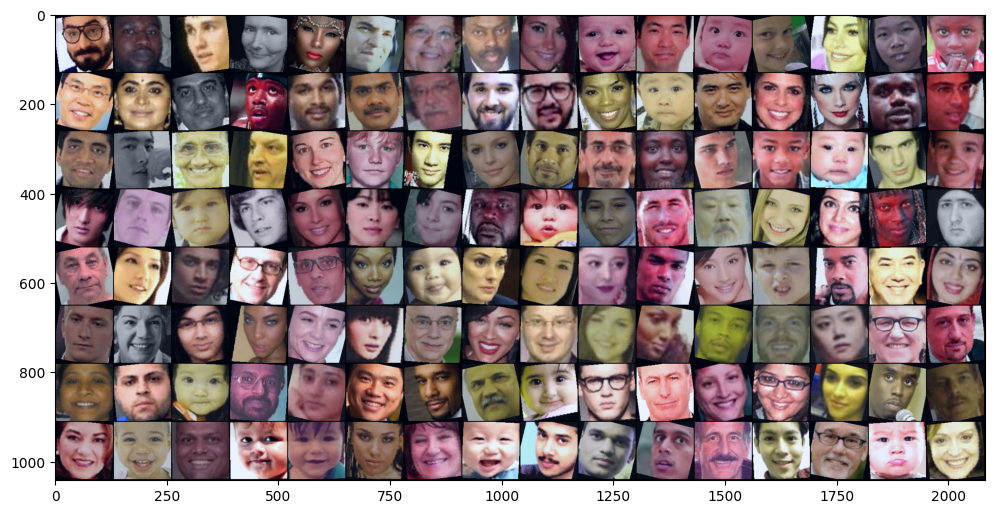

In [ ]:
img_grid = make_grid(imgs, nrow=16, normalize=True).permute(1, 2, 0)
plt.figure(figsize=(12, 8))
plt.imshow(img_grid);

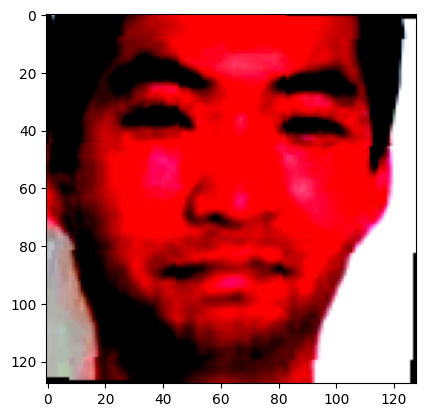

In [ ]:
plt.imshow(imgs[10].permute(1, 2, 0))

# **Model**

In [ ]:
class AgeEstimationModel(nn.Module):

  def __init__(self):
    super().__init__()
    self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    self.model.fc = nn.Linear(in_features=2048, out_features=1, bias=True)

  def forward(self, x):
    y = self.model(x)
    return y

In [ ]:
model = AgeEstimationModel()
model(imgs).shape

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 104MB/s]


torch.Size([128, 1])

#**Config**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
model = model.to(device)

In [ ]:
loss_fn = nn.L1Loss()
loss_fn

L1Loss()

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9, weight_decay=1e-4)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.02
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)

In [ ]:
metric = tm.MeanAbsoluteError().to(device)
metric

MeanAbsoluteError()

In [ ]:
metric.update(torch.tensor(6.), torch.tensor(4.))

In [ ]:
metric.compute()

tensor(2., device='cuda:0')

#**Train**

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch!= None:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      metric.update(outputs, targets)

      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

#**Evaluation**

In [ ]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = AverageMeter()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)
      loss_eval.update(loss.item(), n=len(targets))

      metric(outputs, targets)

  return loss_eval.avg, metric.compute().item()

# **Training Process**

## Finding Hyper-parameters

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.


In [ ]:
model = AgeEstimationModel().to(device)

inputs, targets = next(iter(train_loader))
inputs = inputs.to(device)
targets = targets.to(device)

with torch.no_grad():
  outputs = model(inputs)
  loss = loss_fn(outputs, targets)

print(loss)

tensor(30.5559, device='cuda:0')


In [ ]:
torch.cuda.empty_cache()

### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [ ]:
mini_train_size = 1000
_, mini_train_dataset = random_split(train_set, (len(train_set)-mini_train_size, mini_train_size))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [ ]:
model = AgeEstimationModel().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, metric, epoch)

Epoch 9: 100%|██████████| 50/50 [00:10<00:00,  4.60batch/s, loss=8.11, metric=8.11]


### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [ ]:
num_epochs = 3

for lr in [0.1, 0.01, 0.001, 0.0001]:
  print(f'LR={lr}')

  # define model and optimizer for each learning rate from scratch
  model = AgeEstimationModel().to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)

  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

  print()

LR=0.1


Epoch 2: 100%|██████████| 127/127 [02:03<00:00,  1.03batch/s, loss=10.1, metric=10.1]



LR=0.01


Epoch 2: 100%|██████████| 127/127 [02:03<00:00,  1.03batch/s, loss=6.3, metric=6.3]



LR=0.001


Epoch 2: 100%|██████████| 127/127 [02:03<00:00,  1.03batch/s, loss=5.88, metric=5.88]



LR=0.0001


Epoch 2: 100%|██████████| 127/127 [02:03<00:00,  1.02batch/s, loss=12.9, metric=12.9]

### 🟡 **Step 4**: Create a small grid using the weight decay and the best learning rate.





In [ ]:
num_epochs = 3

for lr in [0.003, 0.001, 0.007]:
  for wd in [1e-4, 1e-5, 0.]:
    print(f'LR={lr}, WD={wd}')

    model = AgeEstimationModel().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

    print()

LR=0.003, WD=0.0001


Epoch 2: 100%|██████████| 127/127 [02:04<00:00,  1.02batch/s, loss=6.69, metric=6.69]



LR=0.003, WD=1e-05


Epoch 2: 100%|██████████| 127/127 [02:09<00:00,  1.02s/batch, loss=6.83, metric=6.83]



LR=0.003, WD=0.0


Epoch 2: 100%|██████████| 127/127 [02:04<00:00,  1.02batch/s, loss=6.76, metric=6.76]



LR=0.001, WD=0.0001


Epoch 2: 100%|██████████| 127/127 [02:06<00:00,  1.01batch/s, loss=10.4, metric=10.4]



LR=0.001, WD=1e-05


Epoch 2: 100%|██████████| 127/127 [02:05<00:00,  1.01batch/s, loss=10.4, metric=10.4]



LR=0.001, WD=0.0


Epoch 2: 100%|██████████| 127/127 [02:02<00:00,  1.03batch/s, loss=10.3, metric=10.3]



LR=0.007, WD=0.0001


Epoch 2: 100%|██████████| 127/127 [02:05<00:00,  1.02batch/s, loss=5.97, metric=5.97]



LR=0.007, WD=1e-05


Epoch 2: 100%|██████████| 127/127 [02:04<00:00,  1.02batch/s, loss=6.03, metric=6.03]



LR=0.007, WD=0.0


Epoch 2: 100%|██████████| 127/127 [02:07<00:00,  1.00s/batch, loss=5.94, metric=5.94]

In [ ]:
num_epochs = 3

for lr in [0.003, 0.001, 0.007]:
  for wd in [1e-4, 1e-5, 0.]:
    print(f'LR={lr}, WD={wd}')

    model = AgeEstimationModel().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

    print()

LR=0.003, WD=0.0001


Epoch 2: 100%|██████████| 127/127 [02:05<00:00,  1.01batch/s, loss=5.78, metric=5.78]



LR=0.003, WD=1e-05


Epoch 2: 100%|██████████| 127/127 [02:04<00:00,  1.02batch/s, loss=5.68, metric=5.68]



LR=0.003, WD=0.0


Epoch 2: 100%|██████████| 127/127 [02:06<00:00,  1.01batch/s, loss=5.66, metric=5.66]



LR=0.001, WD=0.0001


Epoch 2: 100%|██████████| 127/127 [02:05<00:00,  1.01batch/s, loss=6.07, metric=6.07]



LR=0.001, WD=1e-05


Epoch 2: 100%|██████████| 127/127 [02:04<00:00,  1.02batch/s, loss=5.89, metric=5.89]



LR=0.001, WD=0.0


Epoch 2: 100%|██████████| 127/127 [02:02<00:00,  1.03batch/s, loss=5.98, metric=5.98]



LR=0.007, WD=0.0001


Epoch 2: 100%|██████████| 127/127 [02:05<00:00,  1.01batch/s, loss=6.11, metric=6.11]



LR=0.007, WD=1e-05


Epoch 2: 100%|██████████| 127/127 [02:04<00:00,  1.02batch/s, loss=6, metric=6]



LR=0.007, WD=0.0


Epoch 2: 100%|██████████| 127/127 [02:03<00:00,  1.03batch/s, loss=6.15, metric=6.15]

### 🟡 **Step 5**: **Train ALL.** Train model for longer epochs using the best model from step 4.





We write model and optimizer in different cells. So after 10 epoch if we want to change the learning rate and continue runnig the code, we could just change the optimizer and run that cell again not model cell. Because if we run the model cell too, the model would reset.

In [ ]:
model = AgeEstimationModel().to(device)

In [ ]:
lr = 0.003
wd = 1e-05
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 metric,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_loader,
                                     loss_fn,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, MAE = {metric_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 127/127 [02:04<00:00,  1.02batch/s, loss=12.2, metric=12.2]


Valid: Loss = 6.588, MAE = 6.588



Epoch 1: 100%|██████████| 127/127 [02:04<00:00,  1.02batch/s, loss=6.38, metric=6.38]


Valid: Loss = 5.829, MAE = 5.829



Epoch 2: 100%|██████████| 127/127 [02:03<00:00,  1.03batch/s, loss=5.71, metric=5.71]


Valid: Loss = 5.691, MAE = 5.691



Epoch 3: 100%|██████████| 127/127 [02:05<00:00,  1.01batch/s, loss=5.36, metric=5.36]


Model Saved!
Valid: Loss = 5.272, MAE = 5.272



Epoch 4: 100%|██████████| 127/127 [02:03<00:00,  1.03batch/s, loss=5.02, metric=5.02]


Valid: Loss = 5.358, MAE = 5.358



Epoch 5: 100%|██████████| 127/127 [02:03<00:00,  1.02batch/s, loss=4.9, metric=4.9]


Model Saved!
Valid: Loss = 4.939, MAE = 4.939



Epoch 6: 100%|██████████| 127/127 [02:03<00:00,  1.03batch/s, loss=4.67, metric=4.67]


Valid: Loss = 5.164, MAE = 5.164



Epoch 7: 100%|██████████| 127/127 [02:03<00:00,  1.03batch/s, loss=4.59, metric=4.59]


Valid: Loss = 5.04, MAE = 5.04



Epoch 8: 100%|██████████| 127/127 [02:03<00:00,  1.03batch/s, loss=4.44, metric=4.44]


Valid: Loss = 5.042, MAE = 5.042



Epoch 9: 100%|██████████| 127/127 [02:04<00:00,  1.02batch/s, loss=4.25, metric=4.25]


Valid: Loss = 5.247, MAE = 5.247



**5 more poch with lr = 0.001**

In [ ]:
lr = 0.001
wd = 1e-05
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 metric,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_loader,
                                     loss_fn,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, MAE = {metric_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 127/127 [02:19<00:00,  1.10s/batch, loss=3.87, metric=3.87]


Model Saved!
Valid: Loss = 4.723, MAE = 4.723



Epoch 1: 100%|██████████| 127/127 [02:09<00:00,  1.02s/batch, loss=3.64, metric=3.64]


Valid: Loss = 4.775, MAE = 4.775



Epoch 2: 100%|██████████| 127/127 [02:04<00:00,  1.02batch/s, loss=3.54, metric=3.54]


Valid: Loss = 4.73, MAE = 4.73



Epoch 3: 100%|██████████| 127/127 [02:04<00:00,  1.02batch/s, loss=3.45, metric=3.45]


Valid: Loss = 4.751, MAE = 4.751



Epoch 4: 100%|██████████| 127/127 [02:08<00:00,  1.01s/batch, loss=3.36, metric=3.36]


Valid: Loss = 4.746, MAE = 4.746



In [ ]:
!cp /content/test_set.csv /content/drive/MyDrive/Age_Estimation
!cp /content/train_set.csv /content/drive/MyDrive/Age_Estimation
!cp /content/valid_set.csv /content/drive/MyDrive/Age_Estimation
!cp /content/model.pt /content/drive/MyDrive/Age_Estimation

## Plot

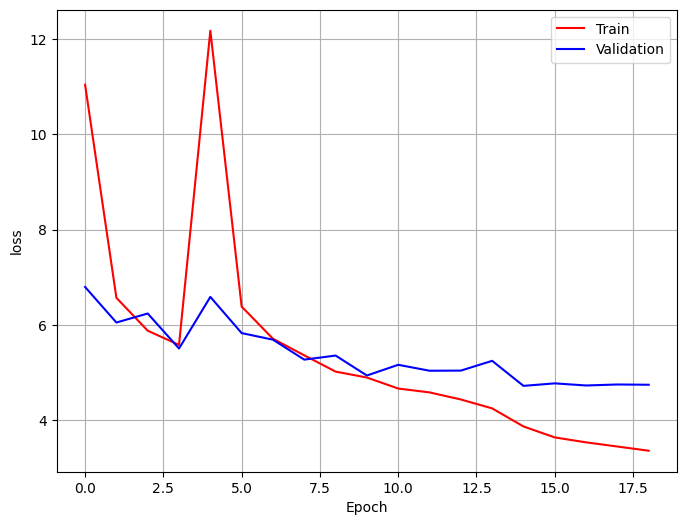

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

#  **Test**

In [ ]:
model_path = '/content/model.pt'
model = torch.load(model_path)
model.eval()

In [ ]:
_, metric_test = evaluate(model, test_loader, loss_fn, metric)
metric_test

4.756894588470459

# **Inference**

In [ ]:
model_path = '/content/model.pt'
model = torch.load(model_path)
model.eval()

In [ ]:
!pip install face-recognition

In [ ]:
import face_recognition

In [ ]:
# test image:
Image.open("/content/Test_image/IMG_20150701_154118.jpg")

In [ ]:
def inference(image_path, transform, model, face_detection=False):
  if face_detection:
    img = face_recognition.load_image_file(image_path)
    top, right, bottom, left = face_recognition.face_locations(img)[0]
    img_crop = img[top:bottom, left:right]
    img_crop = Image.fromarray(img_crop)
  else:
    img_crop = Image.open(image_path).convert('RGB')

  img_tensor = transform(img_crop).unsqueeze(0)
  with torch.inference_mode():
    preds = model(img_tensor.to(device)).item()

  return preds, img_crop

In [ ]:
preds, img = inference('/content/Test_image/IMG_20150701_154118.jpg',
          test_transform, model, face_detection=True)

print(f'{preds:.2f}')
img

Real: 35, Predicted: 33.23


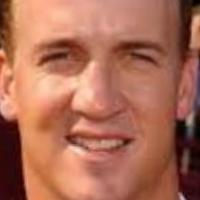

In [ ]:
# Load a random image from a folder
folder_image_path = '/content/dataset/UTKFace'
image_files = os.listdir(folder_image_path)

rand_idx = random.randint(0, len(image_files))
test_image_path = os.path.join(folder_image_path, image_files[rand_idx])
predicted_age, image = inference(test_image_path, test_transform, model)

real_age = image_files[rand_idx].split('_')[0]
print(f"Real: {real_age}, Predicted: {predicted_age:.2f}")
image

Real: 2, Predicted: 3.40


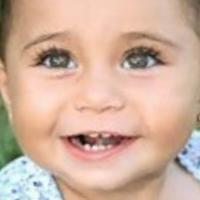

In [ ]:
# Load a random image from a casv file
csv_file_path = '/content/test_set.csv'
df = pd.read_csv(csv_file_path)

rand_idx = random.randint(0, df.shape[0])
test_image_name = df.iloc[rand_idx].image_name
test_image_path = os.path.join(folder_image_path, test_image_name)
predicted_age, image = inference(test_image_path, test_transform, model)

real_age = test_image_name.split('_')[0]
print(f"Real: {real_age}, Predicted: {predicted_age:.2f}")
image

In [ ]:
# Load a random image from a folder
folder_image_path = '/content/Test_image'
image_files = os.listdir(folder_image_path)

# random
# rand_idx = random.randint(0, len(image_files))
# test_image_path = os.path.join(folder_image_path, image_files[rand_idx])
# all
for img in image_files:
  test_image_path = os.path.join(folder_image_path, img)
  predicted_age, image = inference(test_image_path, test_transform, model, face_detection=True)

  # real_age = image_files[rand_idx].split('_')[0]
  print(f"Predicted: {predicted_age:.2f}")
  plt.imshow(image)
  plt.show()

#  **Experiments**

##  Analyze the MAE value with respect to age, gender and race.

In [ ]:
all_outputs, all_targets = [], []

for inputs, targets in test_loader:
  inputs = inputs.to(device)
  targets = targets.to(device)

  with torch.inference_mode():
    outputs = model(inputs)

  all_outputs.append(outputs)
  all_targets.append(targets)

In [ ]:
all_outputs = torch.vstack(all_outputs).squeeze()
all_targets = torch.vstack(all_targets).squeeze()
all_outputs.shape, all_targets.shape

(torch.Size([3475]), torch.Size([3475]))

In [ ]:
mae = F.l1_loss(all_outputs, all_targets, reduction='none')
mae.shape

torch.Size([3475])

In [ ]:
df_test = pd.read_csv('/content/test_set.csv')

df_test['preds'] = all_outputs.cpu()
df_test['maes'] = mae.cpu()
df_test.to_csv('/content/test_outputs.csv')
df_test.head()

,image_name,age,ethnicity,gender,preds,maes
0,56_1_0_20170110123126617.jpg.chip.jpg,56,White,Female,53.216385,2.783615
1,48_0_0_20170116233057278.jpg.chip.jpg,48,White,Male,42.988373,5.011627
2,34_0_0_20170116193345729.jpg.chip.jpg,34,White,Male,36.386463,2.386463
3,46_0_0_20170117190127107.jpg.chip.jpg,46,White,Male,60.956638,14.956638
4,4_0_0_20170110212621808.jpg.chip.jpg,4,White,Male,1.286936,2.713064


In [ ]:
df_test.groupby('age')['maes'].describe()

,count,mean,std,min,25%,50%,75%,max
age,,,,,,,,
1,168.0,0.380742,0.596711,0.000116,0.080825,0.184720,0.406933,4.694531
2,72.0,1.079401,2.674567,0.047924,0.394518,0.745531,0.979621,22.989332
3,43.0,1.234279,1.558153,0.111964,0.517270,0.734821,1.440710,9.089483
4,41.0,1.678440,1.155366,0.030790,0.766488,1.535050,2.433429,4.435630
5,29.0,2.061219,1.670334,0.006113,0.593529,1.610782,3.115861,6.686865
...,...,...,...,...,...,...,...,...
76,8.0,9.902065,5.359700,4.411453,5.863894,7.651340,13.780517,18.290562
77,4.0,9.941780,8.144980,0.716331,4.435061,10.416529,15.923248,18.217731
78,10.0,9.973228,9.789467,1.725258,3.656368,6.885246,12.595075,33.979393


<BarContainer object of 80 artists>

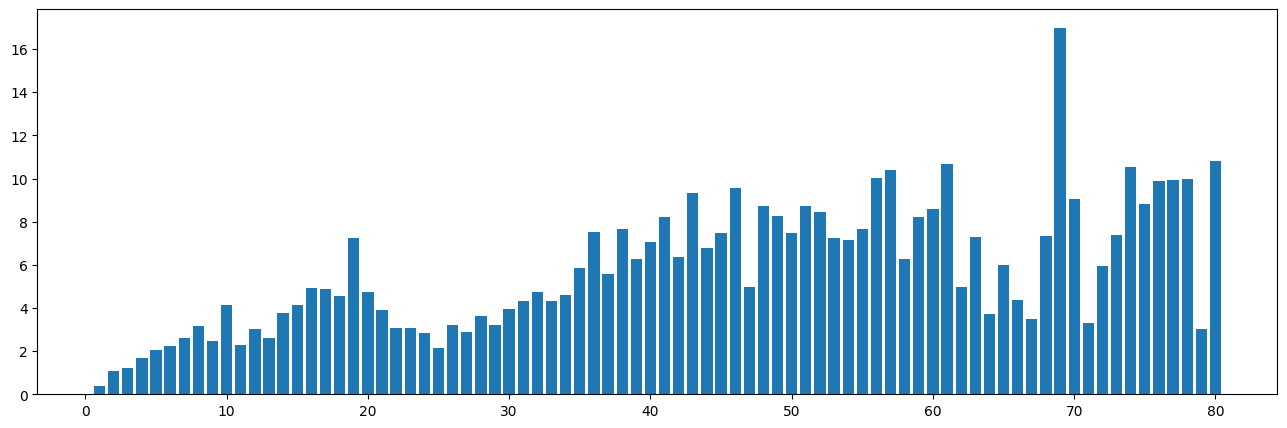

In [ ]:
plt.figure(figsize=(16, 5))
plt.bar(df_test.groupby('age')['maes'].describe().index,
        df_test.groupby('age')['maes'].describe()['mean'])

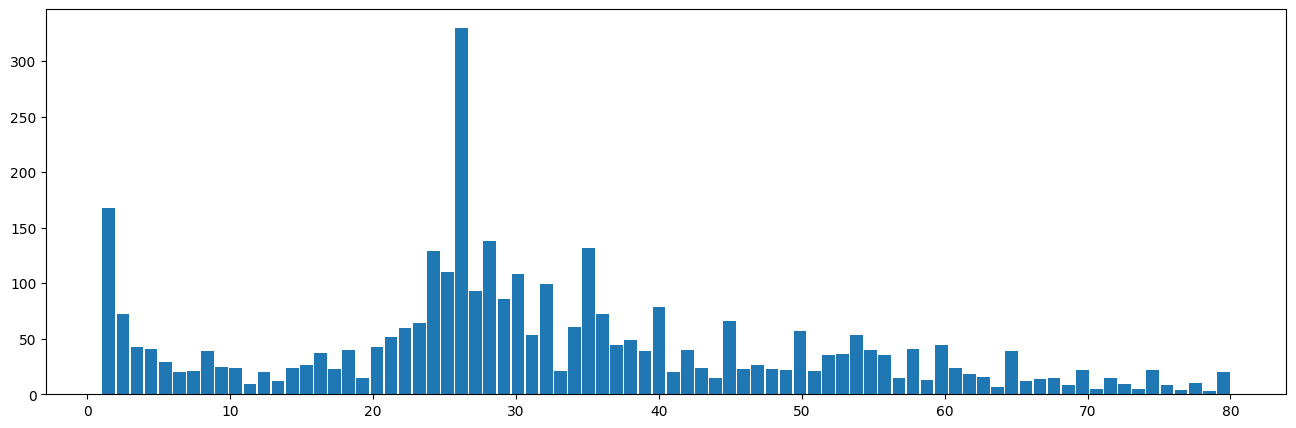

In [ ]:
plt.figure(figsize=(16, 5))
plt.hist(df_test.age, bins=len(df_test.age.unique()), rwidth = 0.9);

In [ ]:
df_test.groupby('gender')['maes'].describe()

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
Female,1642.0,4.688550,5.109753,0.003313,1.123569,3.046684,6.382902,40.423698
Male,1833.0,4.818118,4.963859,0.000116,1.154277,3.412640,6.800133,49.671249


In [ ]:
df_test.groupby('ethnicity')['maes'].describe()

,count,mean,std,min,25%,50%,75%,max
ethnicity,,,,,,,,
Asian,507.0,3.523817,4.200272,0.000354,0.594500,2.035957,4.964260,30.580462
Black,688.0,5.352260,5.207692,0.007784,1.599340,3.889004,7.384004,34.991001
Indian,586.0,4.560556,4.457761,0.001878,1.130245,3.268894,6.564300,28.250130
Others,264.0,3.673665,3.890831,0.033894,0.777719,2.341188,5.321654,20.403286
White,1430.0,5.188074,5.499719,0.000116,1.351652,3.508679,7.016527,49.671249


In [ ]:
ranges = np.arange(df.age.min()-1, df.age.max()+1, 5)
df_test['age_period'] = pd.cut(df.age, bins=ranges)
df_test.head()

,image_name,age,ethnicity,gender,preds,maes,age_period
0,56_1_0_20170110123126617.jpg.chip.jpg,56,White,Female,53.216385,2.783615,"(55, 60]"
1,48_0_0_20170116233057278.jpg.chip.jpg,48,White,Male,42.988373,5.011627,"(45, 50]"
2,34_0_0_20170116193345729.jpg.chip.jpg,34,White,Male,36.386463,2.386463,"(30, 35]"
3,46_0_0_20170117190127107.jpg.chip.jpg,46,White,Male,60.956638,14.956638,"(45, 50]"
4,4_0_0_20170110212621808.jpg.chip.jpg,4,White,Male,1.286936,2.713064,"(0, 5]"


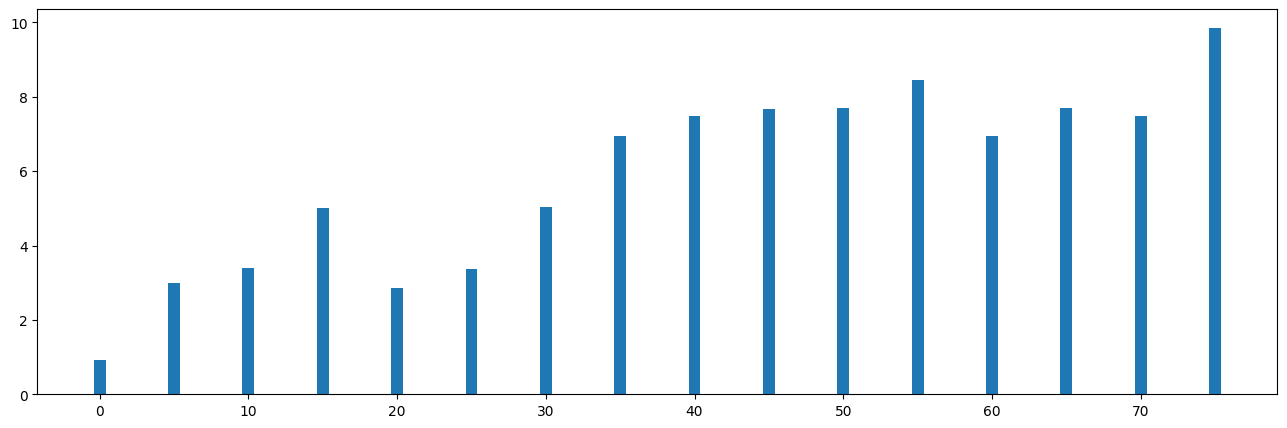

In [ ]:
plt.figure(figsize=(16, 5))
plt.bar(ranges[:-1],
        df_test.groupby('age_period')['maes'].describe()['mean']);

In [ ]:
df_test.groupby('age_period')['maes'].describe().index

CategoricalIndex([  (0, 5],  (5, 10], (10, 15], (15, 20], (20, 25], (25, 30],
                  (30, 35], (35, 40], (40, 45], (45, 50], (50, 55], (55, 60],
                  (60, 65], (65, 70], (70, 75], (75, 80]],
                 categories=[(0, 5], (5, 10], (10, 15], (15, 20], ..., (60, 65], (65, 70], (70, 75], (75, 80]], ordered=True, dtype='category', name='age_period')

In [ ]:
df_test.groupby('age_period')['maes'].describe()

,count,mean,std,min,25%,50%,75%,max
age_period,,,,,,,,
"(0, 5]",353.0,0.915997,1.614134,0.000116,0.159042,0.496513,1.073510,22.989332
"(5, 10]",129.0,2.987741,3.481494,0.029407,0.968053,1.983307,3.452465,19.430204
"(10, 15]",91.0,3.408527,2.858674,0.221329,1.627048,2.163363,4.622621,14.116152
"(15, 20]",158.0,4.996198,3.170712,0.018410,2.841202,4.800722,6.986327,16.024006
"(20, 25]",415.0,2.845943,2.410453,0.019224,0.988963,2.290884,4.079880,15.261955
"(25, 30]",755.0,3.364084,3.901392,0.003313,0.978471,2.262869,4.522080,49.671249
"(30, 35]",366.0,5.023973,3.825055,0.018723,2.212533,4.430657,6.804575,23.326385
"(35, 40]",283.0,6.943694,4.724295,0.065792,3.382339,6.583080,9.775186,27.013493
"(40, 45]",165.0,7.495113,5.108822,0.005344,3.475407,6.608479,11.097954,25.424442
